# Imports and Functions

In [1]:
import numpy as np
import os
import xraydb
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import glob
import re
import pathlib
from tqdm.auto import tqdm

In [2]:
ptable = {
    'H': 1, 'He': 2,
    'Li': 3, 'Be': 4, 'B': 5, 'C': 6, 'N': 7, 'O': 8, 'F': 9, 'Ne': 10,
    'Na': 11, 'Mg': 12, 'Al': 13, 'Si': 14, 'P': 15, 'S': 16, 'Cl': 17, 'Ar': 18,
    'K': 19, 'Ca': 20, 'Sc': 21, 'Ti': 22, 'V': 23, 'Cr': 24, 'Mn': 25, 'Fe': 26, 
    'Co': 27, 'Ni': 28, 'Cu': 29, 'Zn': 30, 'Ga': 31, 'Ge': 32, 'As': 33, 'Se': 34, 
    'Br': 35, 'Kr': 36, 'Rb': 37, 'Sr': 38, 'Y': 39, 'Zr': 40, 'Nb': 41, 'Mo': 42, 
    'Tc': 43, 'Ru': 44, 'Rh': 45, 'Pd': 46, 'Ag': 47, 'Cd': 48, 'In': 49, 'Sn': 50,
    'Sb': 51, 'Te': 52, 'I': 53, 'Xe': 54, 'Cs': 55, 'Ba': 56, 'La': 57, 'Ce': 58, 
    'Pr': 59, 'Nd': 60, 'Pm': 61, 'Sm': 62, 'Eu': 63, 'Gd': 64, 'Tb': 65, 'Dy': 66,
    'Ho': 67, 'Er': 68, 'Tm': 69, 'Yb': 70, 'Lu': 71, 'Hf': 72, 'Ta': 73, 'W': 74, 
    'Re': 75, 'Os': 76, 'Ir': 77, 'Pt': 78, 'Au': 79, 'Hg': 80, 'Tl': 81, 'Pb': 82,
    'Bi': 83, 'Po': 84, 'At': 85, 'Rn': 86, 'Fr': 87, 'Ra': 88, 'Ac': 89, 'Th': 90,
    'Pa': 91, 'U': 92
}

atomic_masses = {
    'H': 1.0, 'He': 4.0, 'Li': 6.9, 'Be': 9.0, 'B': 10.8, 'C': 12.0, 'N': 14.0, 'O': 16.0,
    'F': 19.0, 'Ne': 20.2, 'Na': 22.9, 'Mg': 24.3, 'Al': 26.9, 'Si': 28.1, 'P': 30.9, 'S': 32.1,
    'Cl': 35.4, 'Ar': 39.9, 'K': 39.1, 'Ca': 40.1, 'Sc': 44.9, 'Ti': 47.9, 'V': 50.9, 'Cr': 52.0,
    'Mn': 54.9, 'Fe': 55.8, 'Co': 58.9, 'Ni': 58.7, 'Cu': 63.5, 'Zn': 65.4, 'Ga': 69.7, 'Ge': 72.6,
    'As': 74.9, 'Se': 79.0, 'Br': 79.9, 'Kr': 83.8, 'Rb': 85.5, 'Sr': 87.6, 'Y': 88.9, 'Zr': 91.2,
    'Nb': 92.9, 'Mo': 95.9, 'Tc': 98.0, 'Ru': 101.1, 'Rh': 102.9, 'Pd': 106.4, 'Ag': 107.9, 'Cd': 112.4,
    'In': 114.8, 'Sn': 118.7, 'Sb': 121.8, 'Te': 127.6, 'I': 126.9, 'Xe': 131.3, 'Cs': 132.9, 'Ba': 137.3,
    'La': 138.9, 'Ce': 140.1, 'Pr': 140.9, 'Nd': 144.2, 'Pm': 145.0, 'Sm': 150.4, 'Eu': 152.0, 'Gd': 157.3,
    'Tb': 158.9, 'Dy': 162.5, 'Ho': 164.9, 'Er': 167.3, 'Tm': 168.9, 'Yb': 173.0, 'Lu': 175.0, 'Hf': 178.5,
    'Ta': 180.9, 'W': 183.8, 'Re': 186.2, 'Os': 190.2, 'Ir': 192.2, 'Pt': 195.1, 'Au': 197.0, 'Hg': 200.6,
    'Tl': 204.4, 'Pb': 207.2, 'Bi': 208.9, 'Po': 209.0, 'At': 210.0, 'Rn': 222.0, 'Fr': 223.0, 'Ra': 226.0,
    'Ac': 227.0, 'Th': 232.0, 'Pa': 231.0, 'U': 238.0
}

In [3]:
def find_nearest_index(data, q_val):
    diff_array = np.abs(data[:,0] - q_val)
    diff_array = np.asarray(diff_array)
    index = diff_array.argmin()
    return index

def sq_with_f0(pos, elements, f0_scales, qs):
    '''
    Calculates the scattering profile using the debye equation with atomic scattering factors.

    Input
      pos = scatterer positions in 3D cartesian coordinates (nx3 array)
      elements = 1D array of string of the element symbols for each scatterer
      f0_scales = 1D array of scaling factors for f0 based on solvent electron density contrast
      qs = list of q values to evaluate scattering intensity at
    '''
    nbins = len(qs)
    sq = np.zeros(nbins)
    rij_matrix = squareform(pdist(pos, metric='euclidean'))
    
    # Identify unique elements and precompute f0 for each element and each q value
    unique_elements = np.unique(elements)
    f0_dict = {element: np.array([xraydb.f0(element, q/(4 * np.pi))[0] for q in qs]) for element in unique_elements}

    # Map precomputed f0 values to the elements array
    f0_q_elements = np.array([f0_dict[element] for element in elements])
    f0_q_elements *= f0_scales[:, np.newaxis]  # Adjust f0 values based on solvent contrast scaling

    for i, q_val in enumerate(tqdm(qs)):
        f0_q = f0_q_elements[:, i]  # Atomic scattering factors for this q value
        
        rij_q = rij_matrix * q_val  # Pre-multiply rij by q_val to avoid repetitive computation
        
        # Compute sin(rij * q_val) / (rij * q_val) for all rij elements (this includes rij and rji)
        # division by pi is to account for np.sinc definition of sin(x*pi)/(x*pi)
        sinc_rij_q = np.sinc(rij_q / np.pi)
        
        # Compute contributions to sq for all pairs of points including self-interaction
        sq[i] += np.sum(np.outer(f0_q, f0_q) * sinc_rij_q)
        
    return sq

def plot_convex_hull(coordinates, hull):
    """
    Plots the convex hull and the atomic coordinates of a molecule.

    Parameters:
    - coordinates: np.array, the atomic coordinates of the molecule.
    - hull: ConvexHull object, the convex hull of the molecule.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plotting the atomic coordinates
    ax.scatter(coordinates[:,0], coordinates[:,1], coordinates[:,2], color='r', s=100)

    # Plotting the convex hull
    for simplex in hull.simplices:
        simplex = np.append(simplex, simplex[0])  # loop back to the first vertex
        ax.plot(coordinates[simplex, 0], coordinates[simplex, 1], coordinates[simplex, 2], 'k-')

    # Setting the title
    ax.set_title('Convex Hull Visualization')

    plt.show()

def xyz_simulation(xyz_path, qs, vol_pct, solvent_edens, plot_hull=True):
    """
    Calculates the scattering intensity I(q) for a given molecular structure in an xyz file,
    concentration, and background solvent electron density. Molecular volume is calculated via
    convex hull and background solvent essentially subtracts "z" from each atom in molecule. 
    Note, atoms with Z/(volume/#atoms) less than solvent electron density are removed. 
    Complexity is O(n) for number of q-values and O(n^2) for the number of atoms in .xyz file

    Parameters:
    - xyz_path: string, path to xyz file of molecule, NP, etc
    - qs: 1D array of q values which you would like intensity to be calculated
    - vol_pct: float, volume percent of molecule in solution
    - solvent_edens: float, electron density of solvent in e/Å^3
    - plot_hull: boolean 

    Returns:
    -iq_vals: 1D numpy array of absolute intesntiy values for each q in exp_file
    """
    # Extracting the atomic symbols and positions from the xyz file
    with open(xyz_path, 'r') as file:
        lines = file.readlines()
    # Extracting atom data
    atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
    symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])

    coords = np.array(coords)
    # Calculate molecular volume
    if len(coords) > 3:
        hull = ConvexHull(coords)
        molecular_volume = hull.volume
        #plot hull for verification
        if plot_hull:
            plot_convex_hull(coords, hull)

    else:
        molecular_volume = 0
        if len(coords) == 1:
            print('Insufficient atoms to create hull, approximating atom as sphere with radius 1.5Å')
            molecular_volume = (4/3)*np.pi*1.5**3
        else:
            print('Insufficient atoms to create hull, approximating molecule as cylinder with radius 3Å')
            max_distance = np.max(pdist(coords, metric='euclidean'))
            molecular_volume = max_distance*np.pi*3**2
    
    # Calculate electron density and adjust for solvent contrast
    tot_electrons = sum(ptable[symbol] for symbol in symbols)
    contrast_factor = (solvent_edens * molecular_volume) / len(coords)
    adjusted_electrons = np.array([ptable[symbol] - contrast_factor for symbol in symbols])

    # Filter scatterers based on electron density
    mask = adjusted_electrons > 1
    debye_scatterers = np.array(coords)[mask]
    debye_species = np.array(symbols)[mask]
    f0_scales = adjusted_electrons[mask] / [ptable[s] for s in debye_species]

    edens_scatterer = tot_electrons / molecular_volume
    print(f'scatterer electron density={edens_scatterer}, solvent electron density={solvent_edens}')
    print(f'{len(coords) - np.sum(mask)} atoms were found to have electron density less than solvent.')

    # Compute scattering profile
    sq_vals = sq_with_f0(debye_scatterers, debye_species, f0_scales, qs)
    r0 = 2.82e-13 #thomson scattering length of electron (cm)
    correction_fact = (vol_pct*(r0**2))/(molecular_volume*1e-24)

    iq_vals = sq_vals*correction_fact #absolute intensity (cm^-1)
    return iq_vals

def calc_vf(xyz_path, mass_conc):
    """
    Calculates the unitless volume fraction for a given solution of molecules
    defined in xyz file and given mass concentration in mg/ml. 

    Parameters:
    - xyz_path: string, path to xyz file of molecule, NP, etc
    - mass_conc: float, mass concentration [mg/ml]

    Returns:
    -vol_fract: float, unitless volume fraction of molecules in solution
    """
    # Extracting the atomic symbols and positions from the xyz file
    with open(xyz_path, 'r') as file:
        lines = file.readlines()
    # Extracting atom data
    atom_data = [line.split() for line in lines[2:] if len(line.split()) == 4]
    symbols, coords = zip(*[(parts[0], np.array(list(map(float, parts[1:])))) for parts in atom_data])

    coords = np.array(coords)
    # Calculate molecular volume
    if len(coords) > 3:
        hull = ConvexHull(coords)
        molecular_volume = hull.volume

    else:
        molecular_volume = 0
        if len(coords) == 1:
            print('Insufficient atoms to create hull, approximating atom as sphere with radius 1.5Å')
            molecular_volume = (4/3)*np.pi*1.5**3
        else:
            print('Insufficient atoms to create hull, approximating molecule as cylinder with radius 3Å')
            max_distance = np.max(pdist(coords, metric='euclidean'))
            molecular_volume = max_distance*np.pi*3**2
            
    # Calculate molecule molar mass
    molec_mm = sum(atomic_masses[symbol] for symbol in symbols)
    num_molec_per_ml = ((molec_mm/6.02e23)**-1)*mass_conc/1000
    vol_fract = num_molec_per_ml*molecular_volume*1e-24

    return vol_fract
    

def calc_edens(molec_formula, mass_density):
    """
    molec_formula: str type with format 'Pb1I6' Must include number after each symbol
    mass_density: float type given in g/cm3
    """
    pattern = r'([A-Z][a-z]?)(\d*)'
    tot_electrons = 0
    tot_molarmass = 0 
    for element, count in re.findall(pattern, molec_formula):
        # Convert count to integer, defaulting to 1 if not specified
        count = int(count) if count else 1
        # Lookup atomic number and calculate electrons
        atomic_number = ptable[element]
        molarmass = atomic_masses[element]
        if atomic_number:
            tot_electrons += atomic_number * count
        else:
            raise ValueError(f'Element {element} not found in ptable dictionary.')
        if molarmass:
            tot_molarmass += molarmass * count
        else:
            raise ValueError(f'Element {element} not found in molar mass dictionary.')
            
    molecular_volume = (tot_molarmass/mass_density)*(1e24/6.02e23) #Å^3
    electron_dens = tot_electrons/molecular_volume
    
    return electron_dens

# Load and Visualize Experimental Data

Text(0, 0.5, 'Intensity ($cm^{-1}$)')

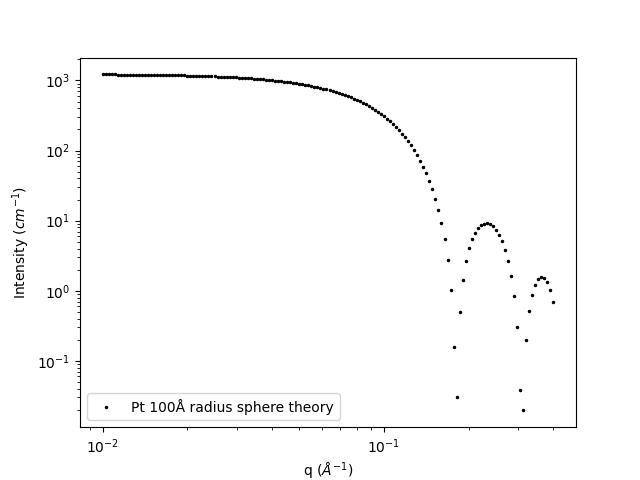

In [132]:
%matplotlib widget
fig, ax1 = subplots(1)
# experimental data should be two column .txt file. Col1=Q[Å^-1] Col2=I
exp_dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/ZnSO4_SAXS/'
exp_file = f'{exp_dirr}verfication_test/pt_sphere_25ang_0p01VF_solv0.txt'
exp_data = np.loadtxt(exp_file)

ax1.plot(exp_data[:,0], exp_data[:,1], label ='Pt 100Å radius sphere theory',
         color='black', linestyle='None', marker = '.', markersize=3)
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.legend()
ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')

# Calculate volume fraction of solute molecules and solvent electron density

In [140]:
#Note: this volume fraction calculator assumes additive volumes of solvent and solute
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/ZnSO4_SAXS/verfication_test/'
xyz_file = f'{dirr}pt_sphere_10ang_radius.xyz'
solution_mass_conc = 280 # mg/ml
vol_fract = calc_vf(xyz_file, solution_mass_conc)
print(f'solution volume fraction is {vol_fract:0.3f}')

solution volume fraction is 0.010


In [141]:
solvent_formula = 'C7H8' # molecular formula for solvent
solvent_mass_dens = 0.867 # g/cm3
solv_edens = calc_edens(solvent_formula, solvent_mass_dens)
print(f'solvent electron density is {solv_edens:0.3f} e/Å^3')

solvent electron density is 0.284 e/Å^3


# Simulate scattering profile of molecules in solution
### Simulator will calculate scattering in absolute units [cm^-1] 
### Note: simulator slightly underestimates particle volume as it treats atoms as points in convex hull calculation. This results in a slight overestimation in scattering intensity that is more prevalent for smaller particles

In [142]:
%matplotlib inline
#define paths for experimental data
dirr = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/ZnSO4_SAXS/verfication_test/'
exp_data = np.loadtxt(f'{dirr}pt_sphere_10ang_0p01VF_solv0.txt')
qs = exp_data[:,0]

#if no experimental data you can just define a list of qs
# qs = np.logspace(-2, 1, 300)

#define xyz filepath of molecule and experimental parameters
xyz_file = f'{dirr}pt_sphere_10ang_radius.xyz'
vol_fract = 0.01
solv_edens = 0

#run simulation and package data
pt_NP_sq_vals = xyz_simulation(xyz_file, qs, vol_fract, solv_edens, plot_hull=False)
total_data = np.vstack((exp_data[:,0], pt_NP_sq_vals))
total_data = np.transpose(total_data)

#save data if desired
# save_path = '/Users/Thomas2/Library/CloudStorage/OneDrive-UCB-O365/Desktop/Research_Stuff/ZnSO4_SAXS/verfication_test/'
# np.savetxt(f'{save_path}pt_sphere_10ang_VF0p01_solvrho0.txt')

scatterer electron density=6.812317484585621, solvent electron density=0
0 atoms were found to have electron density less than solvent.


  0%|          | 0/500 [00:00<?, ?it/s]

# Plot experimental and simulated data to compare

Text(0, 0.5, 'Intensity ($cm^{-1}$)')

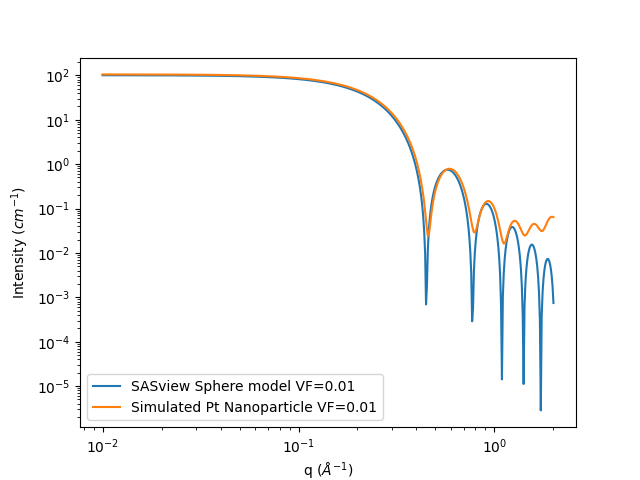

In [143]:
%matplotlib widget
fig, ax1 = subplots(1)
ax1.plot(exp_data[:,0], exp_data[:,1], label='SASview Sphere model VF=0.01')
ax1.plot(total_data[:,0], total_data[:,1], label='Simulated Pt Nanoparticle VF=0.01')
plt.legend()
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('q ($\AA^{-1}$)')
ax1.set_ylabel('Intensity ($cm^{-1}$)')